# Optimizing Drone Hub Locations (Part 1)

## Business understanding

We aim to find the best locations for drone delivery hubs based on customer locations. The goal is to reduce delivery times and improve efficiency.


## Data understanding
We begin by reading the customer location data into a dataframe.  
This dataset contains the x and y coordinates of each customer.


In [411]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load customers locations data
cust_df = pd.read_csv("datasets/drone_cust_locations.csv", sep=';')
print(cust_df.head())

   clientid           x           y
0         1  622.771572  164.857623
1         2  416.357298  630.193634
2         3  292.735020  567.333231
3         4  737.211288  166.225676
4         5  540.475375  682.912298


In [412]:
print(cust_df.columns)

Index(['clientid', 'x', 'y'], dtype='object')


## Data preparation

We visualize the customer locations with scatter plot to get an idea of their distribution.

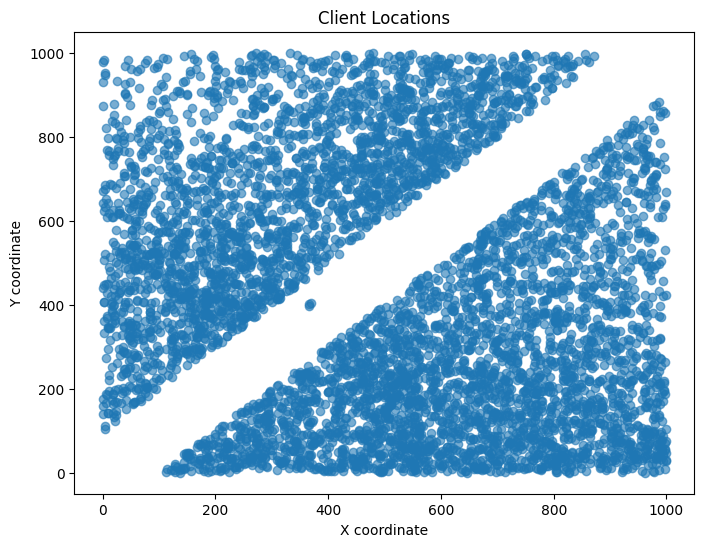

In [413]:
# Visualize customer locations
plt.figure(figsize=(8,6))
plt.scatter(cust_df['x'], cust_df['y'], alpha=0.6)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Client Locations')
plt.show()

The shape going through the scatterplot could be interpreted as a river.

## Modeling

We apply the K-means algorithm to identify optimal depot locations.  
We define the number of depots as 3 and fit the model on the x and y coordinates of the customers. The centroids represent the depot locations.


In [414]:
# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(cust_df[['x', 'y']])

# Get cluster labels
labels = kmeans.labels_

# Print depot (centroid) coordinates
print("Depot coordinates:")
print(kmeans.cluster_centers_)


Depot coordinates:
[[180.89854774 546.02319994]
 [626.30514798 179.0966322 ]
 [641.78201689 758.34167274]]


We visualize the clustering results, showing the customer locations grouped by depot assignment. Black 'X' markers indicate the depot centroids.

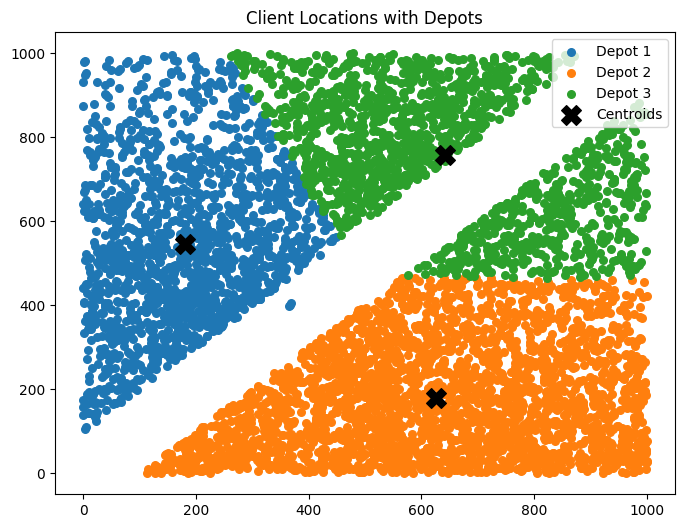

In [415]:
def plot_kmeans(num_depots):
    plt.figure(figsize=(8,6))
    
    # Get the fresh labels from the kmeans model
    labels = kmeans.labels_
    
    # Loop through each depot (cluster)
    for i in range(num_depots):
        
        # Plot the clients that belong to the current depot
        # labels == i selects only the customers assigned to depot i
        # [:, 0] selects x-coordinates
        # [:, 1] selects y-coordinates
        plt.scatter(
            cust_df[['x', 'y']].values[labels == i, 0], 
            cust_df[['x', 'y']].values[labels == i, 1],
            s=30,  # Customer marker size
            label=f'Depot {i+1}'   # Add legend label
        )
    
    # Plot the centroid locations (depot positions)
    plt.scatter(
        kmeans.cluster_centers_[:, 0],  # x-coordinates of centroids
        kmeans.cluster_centers_[:, 1],  # y-coordinates of centroids
        c='black',                    
        marker='X',                     
        s=200,                          # X marker size
        label='Centroids'
    )
    
    
    plt.title('Client Locations with Depots')
    plt.legend()
    plt.show()
    
plot_kmeans(3)


The scatterplot shows that customers are distributed over triangular-shaped areas. 
The central part of the region contains noticeably fewer customers compared to the surrounding areas, but it is not completely empty. This may indicate that the area has lower population density or fewer residential zones compared to the surrounding parts of the area.

Overall, customer locations form three main geographic groupings, but within each group there are also variations in density.
Each depot is positioned near the center of its respective customer area.


Next, we attach the cluster label to each client. 
The cluster labels produced by the k-means model indicate which depot is closest to each customer.


In [416]:
# Add cluster labels to the dataframe
cust_df['Depot'] = labels

# Print the first 10 rows
cust_df.head(10)

,clientid,x,y,Depot
0,1,622.771572,164.857623,1
1,2,416.357298,630.193634,0
2,3,292.735020,567.333231,0
3,4,737.211288,166.225676,1
4,5,540.475375,682.912298,2
5,6,535.469492,318.439661,1
6,7,640.380050,870.833221,2
7,8,235.772075,359.048203,0
8,9,481.896884,661.491838,2
9,10,730.032789,312.177817,1


## K-means Clustering Evaluation

Here, we plot differing cluster amount within-cluster sum of squared distances to see an estimation where the best 'k' could be.

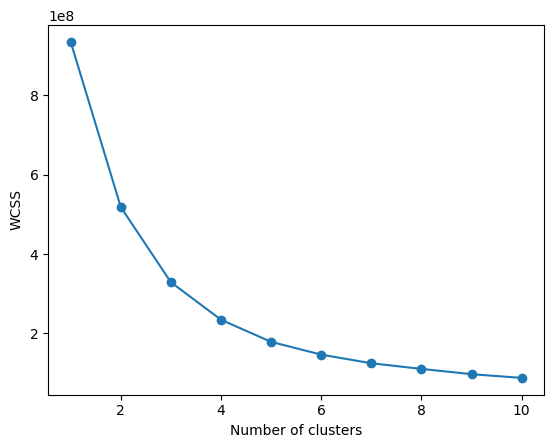

In [417]:
wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(cust_df[['x', 'y']])
    wcss.append(model.inertia_)
    
plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

According to the elbow rule, it seems to be either 3 or 4 clusters.


The silhouette score seems to covey that clustering was fairly effective:

In [418]:
from sklearn.metrics import silhouette_score

print('Silhouette score = %.2f' % silhouette_score(cust_df[['x', 'y']], labels))

Silhouette score = 0.43


Next, we tried these different cluster amounts in practice:

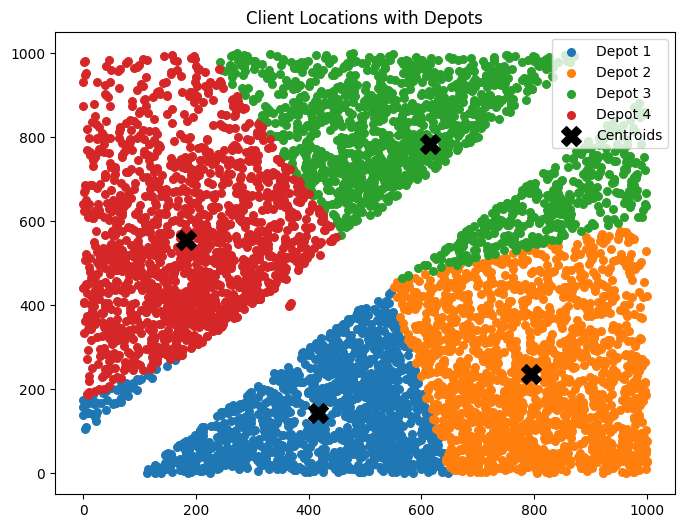

In [419]:
# With 4 clusters
kmeans.n_clusters = 4
kmeans.fit(cust_df[['x', 'y']])
plot_kmeans(4)


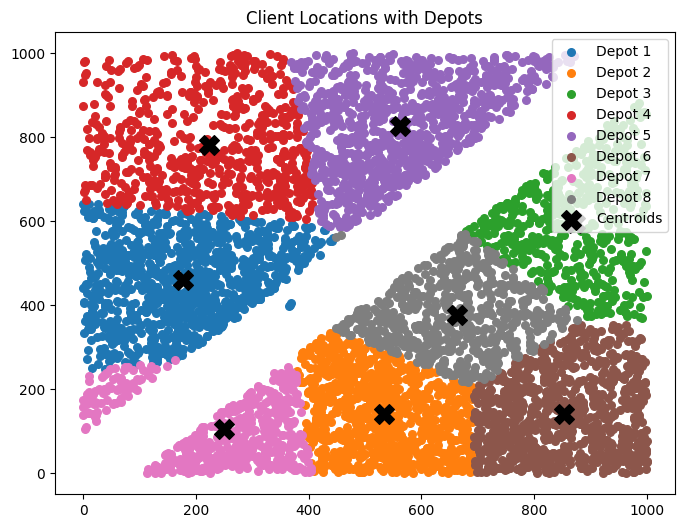

Silhouette score = 0.43


In [420]:
# With 8 clusters
kmeans.n_clusters = 8
kmeans.fit(cust_df[['x', 'y']])
plot_kmeans(8)

print('Silhouette score = %.2f' % silhouette_score(cust_df[['x', 'y']], labels))

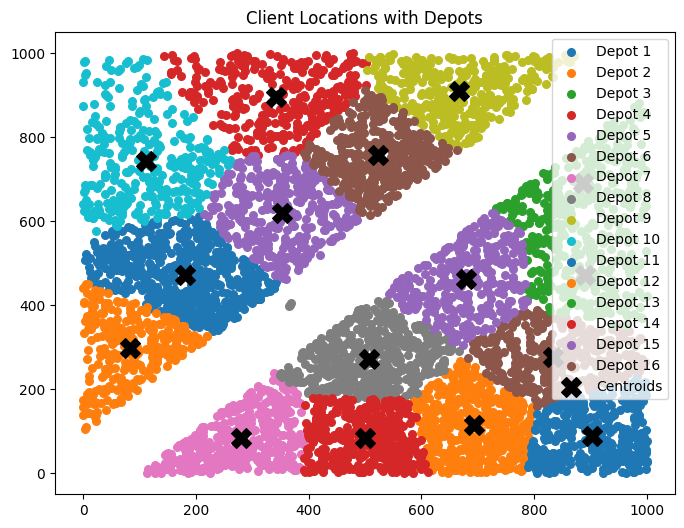

Silhouette score = 0.43


In [421]:
# With 16 clusters
kmeans.n_clusters = 16
kmeans.fit(cust_df[['x', 'y']])
plot_kmeans(16)

print('Silhouette score = %.2f' % silhouette_score(cust_df[['x', 'y']], labels))

In practice, the performance of naive implementation of k-means clustering seems to be fairly linear. 

# Agglomerative Clustering

Next, we tried using agglomerative clustering instead:

## Preparation

In [422]:
from sklearn.cluster import AgglomerativeClustering

Helper function to calculate cluster centers:

In [423]:
import numpy as np

# Calculate cluster centers as the mean of points in each cluster
def calculate_agg_cluster_centers(clusters):
    cluster_centers = []
    for i in range(clusters): 
        cluster_points = cust_df[['x', 'y']].values[labels == i]
        center = np.mean(cluster_points, axis=0)
        cluster_centers.append(center)
    
    return np.array(cluster_centers)


Plot function for agglomerative clustering:

In [424]:
def plot_agglomerative_clustering(cluster_centers):
    plt.figure(figsize=(8,6))
    
    # Get the labels from the model
    labels = agg_model.labels_
    
    # Use a larger set of colors than the default matplotlib 10 to visualize
    cmap = plt.colormaps['tab20']
    colors = [cmap(i % 20) for i in range(len(cluster_centers))]
    
    # Loop through each cluster
    for i in range(len(cluster_centers)):
        plt.scatter(
            cust_df[['x', 'y']].values[labels == i, 0], 
            cust_df[['x', 'y']].values[labels == i, 1],
            c=[colors[i]],
            s=30,
            label=f'Cluster {i+1}'
        )
    
    # Plot the cluster centers (depot positions)
    plt.scatter(
        cluster_centers[:, 0],
        cluster_centers[:, 1],
        c='black',                    
        marker='X',                     
        s=200,
        label='Depots (Cluster Centers)'
    )
    
    plt.title('Client Locations with Depots (Hierarchical Clustering)')
    plt.legend()
    plt.show()


## Modeling

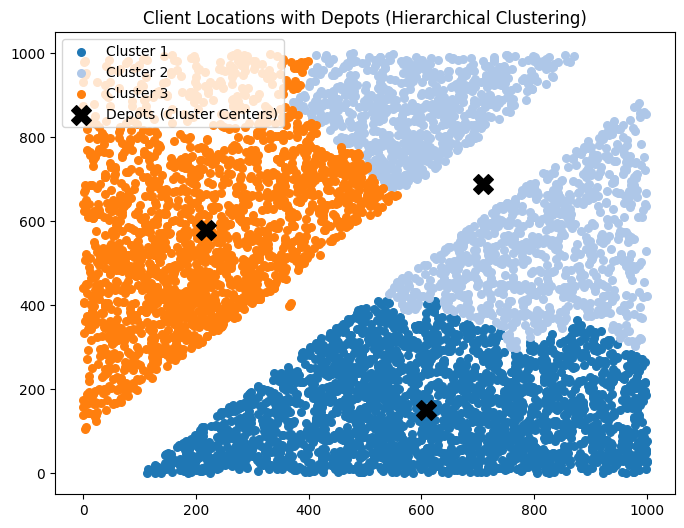

In [425]:
# Fit
agg_model = AgglomerativeClustering(n_clusters=3)
labels = agg_model.fit_predict(cust_df[['x', 'y']])

centers = calculate_agg_cluster_centers(3)
plot_agglomerative_clustering(centers)

In [426]:
print('Silhouette score = %.2f' % silhouette_score(cust_df[['x', 'y']], labels))

Silhouette score = 0.41


With 8 clusters:

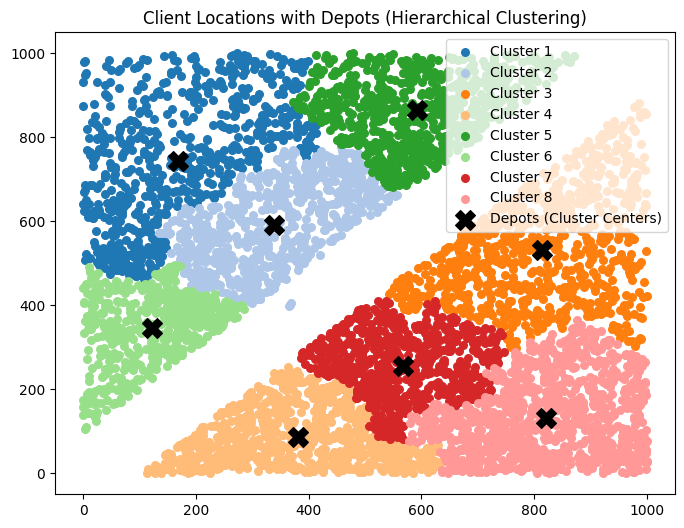

Silhouette score = 0.35


In [427]:
agg_model = AgglomerativeClustering(n_clusters=8)
labels = agg_model.fit_predict(cust_df[['x', 'y']])

centers = calculate_agg_cluster_centers(8)
plot_agglomerative_clustering(centers)

print('Silhouette score = %.2f' % silhouette_score(cust_df[['x', 'y']], labels))

With 16 clusters:

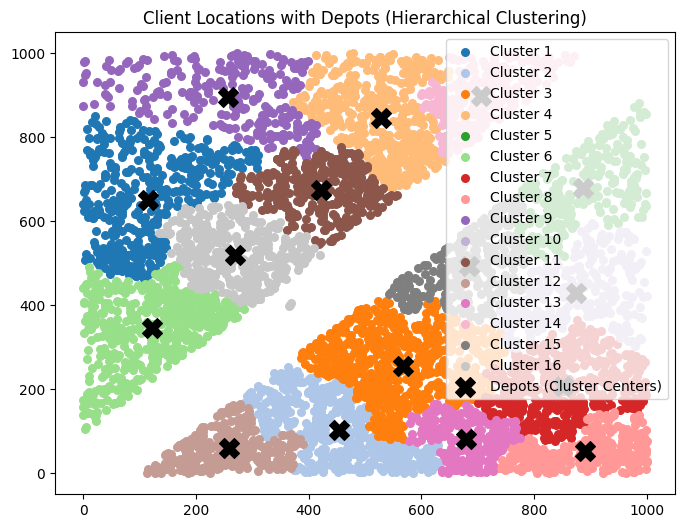

Silhouette score = 0.30


In [428]:
agg_model = AgglomerativeClustering(n_clusters=16)
labels = agg_model.fit_predict(cust_df[['x', 'y']])

centers = calculate_agg_cluster_centers(16)
plot_agglomerative_clustering(centers)

print('Silhouette score = %.2f' % silhouette_score(cust_df[['x', 'y']], labels))

## Agglomerative Clustering Evaluation

We observe that agglomerative clustering is markedly slower for its O(N**3). Silhoutte scores are lower across the board, implying that with this dataset agglomerative clustering is less effective than the k-means algorithm.

# Deployment and Conclusions

Firstly, the depots should always be placed in a somewhat equidistant manner over the area. The shoreline along the river should form a clear divide between cluster centers (depot locations) if the number of depots increase beyond 3.

K-means clustering creates more clear divisions between clusters, while agglomerative clusters are ragged, which could mean that k-means is easier to put into practice and maintain.

Since k-means silhouette scores are also higher, we would recommend a business to divide their drone service areas more along the lines of k-means clustering.